In [1]:
import pandas as pd
from geopy import Point
import numpy as np
from geopy import distance
from numba import njit
from scipy.optimize import optimize
from skopt import gp_minimize
import skopt.plots as skplt
import matplotlib.pyplot as plt


/Users/lucaswebb/.pyenv/versions/3.9.6/envs/ukraine/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:

data = pd.read_csv('2013_Events.csv')
data['Event start date'] = pd.to_datetime(data['Event start date'])
data = data.sort_values(by = 'Event start date')
data = data.loc[data['Event start date'] > '2013-11-15']

In [3]:
print(data.loc[data['Oblast'] == 'Ukraine'].shape[0])
print(data.loc[data['Oblast'] == 'Ukraine']['Location'])

26
5897                                          Web
5898                                          Web
5902                                          Web
5903                                          Web
5899                                          Web
5900    Donetsk-Kharkiv highway, Boryspil highway
5901    Donetsk-Kharkiv highway, Boryspil highway
5904                                          Web
5905                                          Web
5906                                          Web
5908                                          Web
5907                                          Web
5909                                      Ukraine
5910                                          Web
5911                                          Web
5912                                          Web
5913                                          Web
5914                                          Web
5915                                          Web
5916                                          W

In [4]:
data = data.loc[data['Oblast'] != 'Ukraine']
data['Number of events'] = 0
data = data.groupby(['Event start date', 'Oblast'], as_index=False).aggregate({'Number of events': 'size', 'Number of protesters': 'sum'})

data['Event start date'] = pd.to_numeric(data['Event start date'])
data['Event start date'] = ((data['Event start date']-1384560000000000000)/86400000000000).astype(int)

In [5]:
# Weighted centroid by population?

oblast_coords = {'Cherkasy':Point(49.4444, 32.0598), 'Chernihiv':Point(51.4982, 31.2893), 'Chernivtsi':Point(48.2917, 25.9352),
                 'Crimea':Point(45.3453, 34.4997), 'Dnipropetrovsk':Point(48.4647, 35.0462),
                 'Donetsk':Point(48.0159, 37.8028), 'Ivano-Frankivsk':Point(48.9226, 24.7111),
                 'Kharkiv':Point(49.9935, 36.2304), 'Kherson':Point(46.6354, 32.6169),
                 'Khmelnytskyi':Point(49.4230, 26.9871), 'Kirovohrad':Point(48.5079, 32.2623),
                 'Kyiv':Point(50.0530, 30.7667), 'Luhansk':Point(48.5740, 39.3078),
                 'Lutsk':Point(50.7472, 25.3254), 'Lviv':Point(49.8397, 24.0297),
                 'Mykolaiv':Point(46.9750, 31.9946), 'Odesa':Point(46.4846, 30.7326),
                 'Poltava':Point(49.5883, 34.5514), 'Rivne':Point(50.6199, 26.2516),
                 'Sumy':Point(50.9077, 34.7981), 'Ternopil':Point(49.5535, 25.5948),
                 'Uzhhorod':Point(48.6208, 22.2879), 'Vinnytsia':Point(49.2331, 28.4682),
                 'Zaporizhzhia':Point(47.8388, 35.1396), 'Zhytomyr':Point(50.2547, 28.6587)}

In [6]:
data.tail()
# 46 days, 25 oblasts, 756 entries

,Event start date,Oblast,Number of events,Number of protesters
751,45,Donetsk,6,46.0
752,45,Kharkiv,2,58.0
753,45,Poltava,1,0.0
754,45,Rivne,2,101.0
755,45,Ternopil,3,0.0


In [7]:
oblasts = data['Oblast'].unique()

In [8]:
print(oblasts)

['Chernihiv' 'Donetsk' 'Ivano-Frankivsk' 'Kirovohrad' 'Kyiv' 'Lviv'
 'Mykolaiv' 'Odesa' 'Sumy' 'Vinnytsia' 'Zaporizhzhia' 'Crimea' 'Kharkiv'
 'Rivne' 'Luhansk' 'Cherkasy' 'Chernivtsi' 'Poltava' 'Zhytomyr' 'Lutsk'
 'Uzhhorod' 'Dnipropetrovsk' 'Kherson' 'Khmelnytskyi' 'Ternopil']


In [9]:
# Fill in missing entries
rows_list = []
for i in range(0, 46):
    for oblast in oblasts:
        if oblast not in data.loc[data['Event start date'] == i]['Oblast'].values:
            rows_list.append({'Event start date':i, 'Oblast':oblast, 'Number of events':0, 'Number of protesters':0.0})
data = data.append(rows_list, ignore_index=True)

In [10]:
data = data.sort_values(by=['Event start date', 'Oblast'])

In [11]:
data.tail()

,Event start date,Oblast,Number of events,Number of protesters
755,45,Ternopil,3,0.0
1147,45,Uzhhorod,0,0.0
1139,45,Vinnytsia,0,0.0
1140,45,Zaporizhzhia,0,0.0
1145,45,Zhytomyr,0,0.0


In [12]:
# Map oblast strings to ints
int_oblast = {}
oblast_int = {}
for i, str in enumerate(sorted(oblasts)):
    int_oblast[i] = str
    oblast_int[str] = i

In [13]:
# Calculate distance matrix
distances = [[0 for x in range(25)] for x in range(25)]
for i in range (0, 25):
    for j in range(0, 25):
        if i != j:
            distances[i][j] = distance.distance(oblast_coords[int_oblast[i]], oblast_coords[int_oblast[j]]).km
        else:
            distances[i][j] = 0

In [14]:
distance_weights = [[1/(np.power((1 * distances[i][j] + 1), 1)) for j in range(0, 25)] for i in range(0, 25)]

In [15]:
distance_weights[10][0]

0.009416450554973763

In [16]:
# Create new dataframe to be used in simulation
data_sim = data.copy()
data_sim['simulated'] = 0
data_sim['loss'] = 0
data_sim = data_sim.reset_index()
data_sim = data_sim.drop(columns=['index'])
data_sim = data_sim.sort_values(by=['Event start date', 'Oblast'])
data_sim['Oblast'] = [oblast_int[x] for x in data_sim['Oblast']]

In [17]:
data_sim.tail()

,Event start date,Oblast,Number of events,Number of protesters,simulated,loss
1145,45,20,3,0.0,0,0
1146,45,21,0,0.0,0,0
1147,45,22,0,0.0,0,0
1148,45,23,0,0.0,0,0
1149,45,24,0,0.0,0,0


In [18]:
raw_data = data_sim.to_numpy()

In [19]:
raw_data

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  4.,  7.,  0.,  0.],
       [ 0.,  2.,  0.,  0.,  0.,  0.],
       ...,
       [45., 22.,  0.,  0.,  0.,  0.],
       [45., 23.,  0.,  0.,  0.,  0.],
       [45., 24.,  0.,  0.,  0.,  0.]])

In [20]:
def computeLoss(model, actual):
    return (model - (actual * np.log(model))).sum()

In [21]:
@njit
def toMinimizeHelper(params, N0s, dists, raw):
    raw_copy = raw.copy()
    distance_weights = [[1/(np.power((params[2] * dists[i][j] + 1), params[3])) for j in range(0, 25)] for i in range(0, 25)]
    for i in range(0, 46):
        for j in range(25*i, 25*(i+1)):
            psum = np.array([distance_weights[int(raw_copy[j][1])][int(raw_copy[x][1])] *
                             (raw_copy[x][2]*(np.exp((-(i-raw_copy[x][0]-1))/params[1])
                                              - np.exp(-(i-raw_copy[x][0])/params[1]))) for x in range(0, i*25)])
            raw_copy[j][4] = N0s[int(raw_copy[j][1])] + params[0] * psum.sum()
            if j != 0:
                raw_copy[j][5] = raw_copy[j-1][5] + (raw_copy[j][4] - (raw_copy[j][2] * np.log(raw_copy[j][4])))
            # need else statement here
            if np.isnan(psum.sum()):
                print(i)
                print(j)
                print(params)
    # print(raw_copy[1149][5])
    return raw_copy[1149][5]

In [22]:
background_dict = {'Cherkasy': 0.30789648307896483, 'Chernihiv': 0.20305242203052423, 'Chernivtsi': 0.19177173191771732, 'Crimea': 0.7040477770404777, 'Dnipropetrovsk': 0.3158593231585932, 'Donetsk': 0.5693430656934306, 'Ivano-Frankivsk': 0.3297942932979429, 'Kharkiv': 0.8467153284671532, 'Kherson': 0.24220305242203052, 'Khmelnytskyi': 0.11811546118115461, 'Kirovohrad': 0.05308560053085601, 'Kyiv': 2.18978102189781, 'Luhansk': 0.2581287325812873, 'Lutsk': 0.2667551426675514, 'Lviv': 0.927007299270073, 'Mykolaiv': 0.53085600530856, 'Odesa': 0.8566688785666888, 'Poltava': 0.2541473125414731, 'Rivne': 0.16257465162574652, 'Sumy': 0.192435301924353, 'Ternopil': 0.3729263437292634, 'Uzhhorod': 0.08294625082946251, 'Vinnytsia': 0.20437956204379562, 'Zaporizhzhia': 0.08294625082946251, 'Zhytomyr': 0.26940942269409424}

N = []
for key in background_dict.keys():
    N.append(background_dict[key])
N = np.asarray(N)

p = np.asarray([0.63, 1.7, 10, 10])

distances = np.asarray(distances)

In [23]:
%%time
toMinimizeHelper(p, N, distances, raw_data)

CPU times: user 432 ms, sys: 16.5 ms, total: 449 ms
Wall time: 474 ms


331.88441677632915

In [24]:
def toMinimize(params):
    params = np.asarray(params)
    return toMinimizeHelper(params, N, distances, raw_data)

In [25]:
print(toMinimize([0.62, 1, 6, 6]))

393.00353829745967


In [30]:
%%time
res = gp_minimize(toMinimize, [(0.0, 1.0), (0.01, 5.0), (0.0, 4.0), (0.0, 4.0)], n_calls=100, noise=1e-10, n_initial_points=10, random_state=123)

CPU times: user 56.6 s, sys: 7.74 s, total: 1min 4s
Wall time: 50.1 s


In [31]:
res.x

[0.7890619531957594, 3.0294787675806947, 4.0, 4.0]

In [32]:
res.fun

286.4899228833588

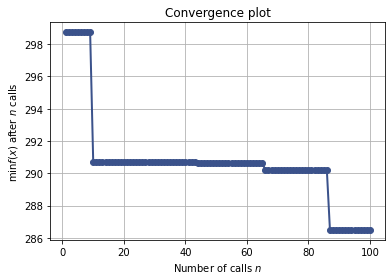

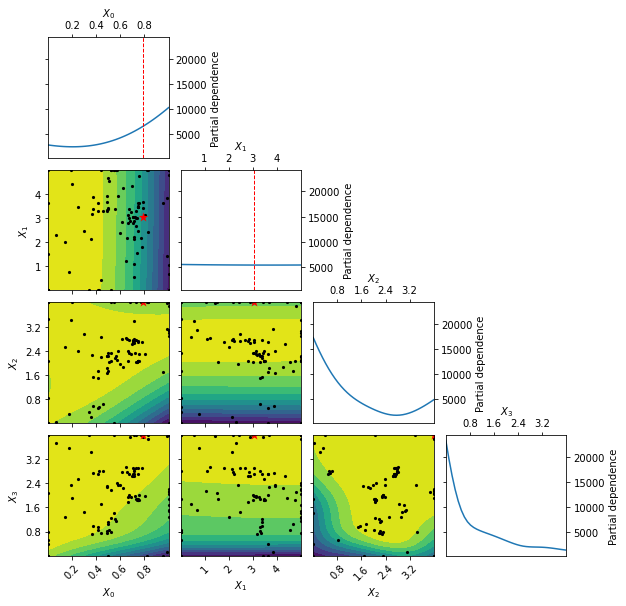

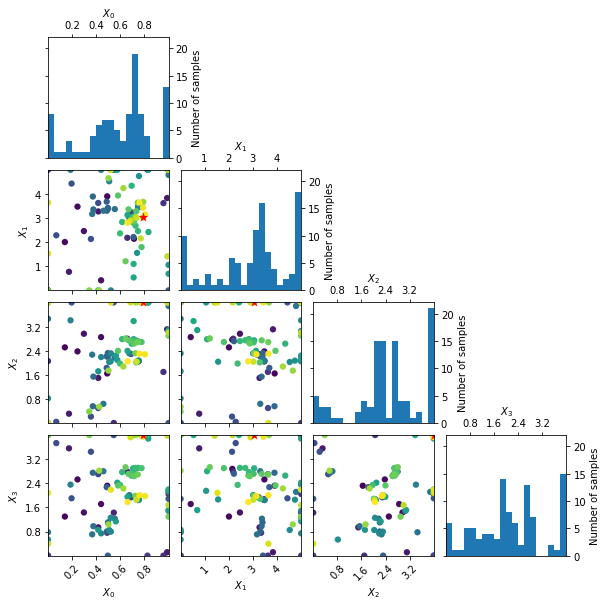

In [33]:
skplt.plot_convergence(res);
skplt.plot_objective(res);
skplt.plot_evaluations(res);

In [34]:
@njit
def simulate(params, N0s, dists, raw):
    raw_copy = raw.copy()
    distance_weights = [[1/(np.power((params[2] * dists[i][j] + 1), params[3])) for j in range(0, 25)] for i in range(0, 25)]
    for i in range(0, 46):
        for j in range(25*i, 25*(i+1)):
            psum = np.array([distance_weights[int(raw_copy[j][1])][int(raw_copy[x][1])] *
                             (raw_copy[x][2]*(np.exp((-(i-raw_copy[x][0]-1))/params[1])
                                              - np.exp(-(i-raw_copy[x][0])/params[1]))) for x in range(0, i*25)])
            raw_copy[j][4] = N0s[int(raw_copy[j][1])] + params[0] * psum.sum()
            if j != 0:
                raw_copy[j][5] = raw_copy[j-1][5] + (raw_copy[j][4] - (raw_copy[j][2] * np.log(raw_copy[j][4])))
            if np.isnan(psum.sum()):
                print(params)
    return raw_copy

In [35]:
sim_data = simulate(np.asarray([res.x[0], res.x[1], res.x[2], res.x[3]]), N, distances, raw_data)

In [36]:
sim_df = pd.DataFrame({'Event start date':sim_data[:, 0], 'Oblast':sim_data[:, 1], 'Number of events':sim_data[:, 2],
                       'Number of protesters':sim_data[:, 3], 'Simulated':sim_data[:, 4], 'loss':sim_data[:, 5]})

In [37]:
sim_df.tail()

,Event start date,Oblast,Number of events,Number of protesters,Simulated,loss
1145,45.0,20.0,3.0,0.0,1.636686,283.427271
1146,45.0,21.0,0.0,0.0,0.511736,283.939007
1147,45.0,22.0,0.0,0.0,1.145558,285.084565
1148,45.0,23.0,0.0,0.0,0.782383,285.866948
1149,45.0,24.0,0.0,0.0,0.622974,286.489923


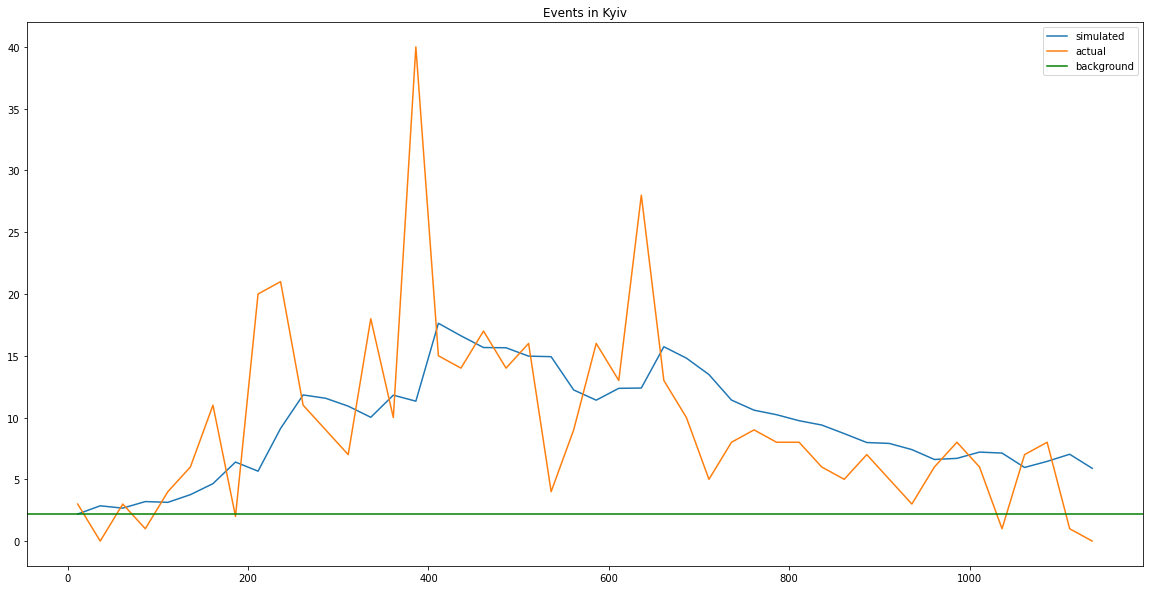

In [38]:
oblast = oblast_int['Kyiv']
plt.figure(figsize=(20,10))
plt.plot(sim_df.loc[sim_df['Oblast']==oblast]['Simulated'], label='simulated')
plt.plot(sim_df.loc[sim_df['Oblast']==oblast]['Number of events'], label='actual')
plt.axhline(y=N[oblast], color='g', label='background')
plt.title("Events in Kyiv")
plt.legend()

In [39]:
computeLoss(sim_df.loc[sim_df['Oblast']==oblast]['Simulated'], sim_df.loc[sim_df['Oblast']==oblast]['Number of events'])

-579.1603634890862

In [40]:
computeLoss(sim_df['Number of events'], sim_df['Number of events'])

/Users/lucaswebb/.pyenv/versions/3.9.6/envs/ukraine/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


-846.702061520878

In [41]:
computeLoss(sim_df['Simulated'], sim_df['Number of events'])

286.7978193664378

In [42]:
# Double check
total = 0
for i in range(0, 25):
    total += computeLoss(sim_df.loc[sim_df['Oblast']==i]['Simulated'], sim_df.loc[sim_df['Oblast']==i]['Number of events'])
print(total)

286.7978193664378


In [43]:
# Look at the null hypothesis of a non-distance dependent model
def toMinimize2(params):
    params = np.append(np.asarray(params), [0.0, 0.0])
    return toMinimizeHelper(params, N, distances, raw_data)

In [44]:
%%time
res2 = gp_minimize(toMinimize2, [(0.0, 1.0), (0.01, 10.0)], n_calls=60, noise=1e-10, n_initial_points=10, random_state=123)

CPU times: user 12.9 s, sys: 673 ms, total: 13.6 s
Wall time: 13.5 s


In [45]:
res2.x

[0.027966180811300968, 0.8121062756488839]

In [46]:
res2.fun

434.2823778479435

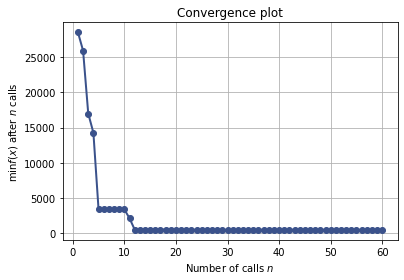

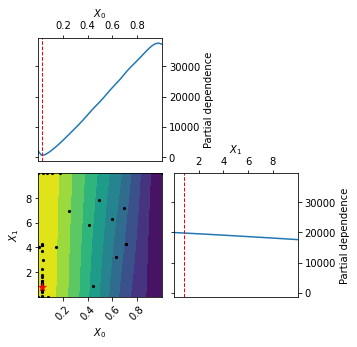

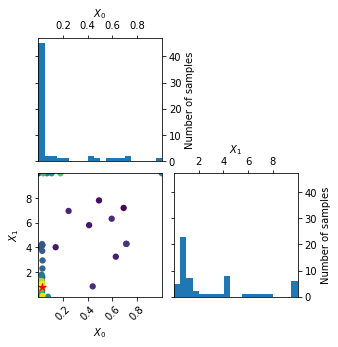

In [47]:
skplt.plot_convergence(res2);
skplt.plot_objective(res2);
skplt.plot_evaluations(res2);

In [48]:
sim_data = simulate(np.asarray([res2.x[0], res2.x[1], 0, 0]), N, distances, raw_data)

In [49]:
sim_df = pd.DataFrame({'Event start date':sim_data[:, 0], 'Oblast':sim_data[:, 1], 'Number of events':sim_data[:, 2],
                       'Number of protesters':sim_data[:, 3], 'Simulated':sim_data[:, 4], 'loss':sim_data[:, 5]})

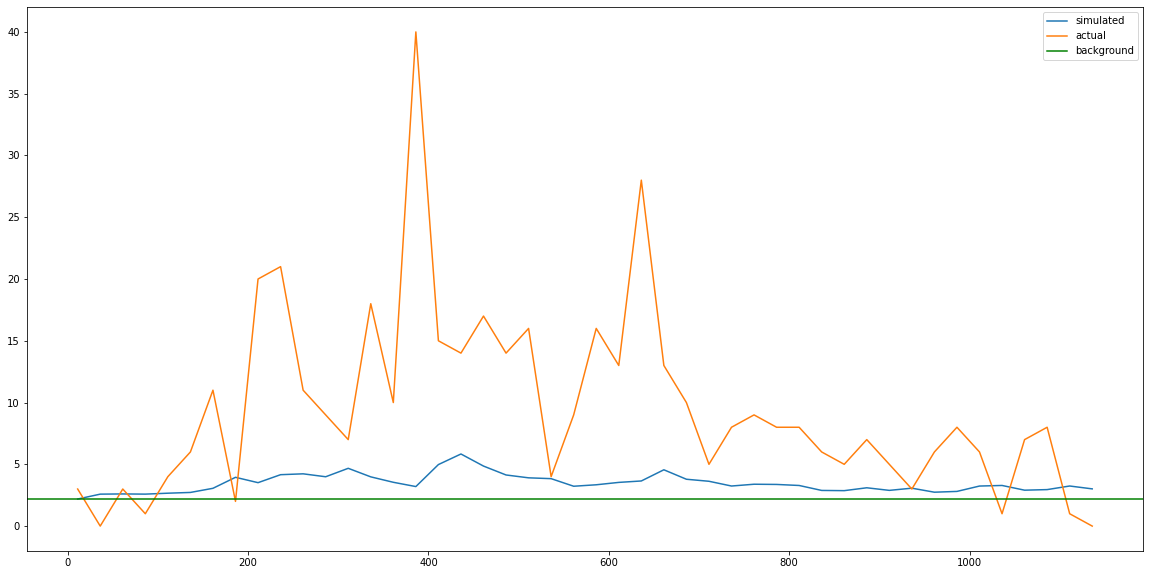

In [50]:
oblast = oblast_int['Kyiv']
plt.figure(figsize=(20,10))
plt.plot(sim_df.loc[sim_df['Oblast']==oblast]['Simulated'], label='simulated')
plt.plot(sim_df.loc[sim_df['Oblast']==oblast]['Number of events'], label='actual')
plt.axhline(y=N[oblast], color='g', label='background')
plt.legend()

In [51]:
sim_df.tail()

,Event start date,Oblast,Number of events,Number of protesters,Simulated,loss
1145,45.0,20.0,3.0,0.0,1.195652,430.351792
1146,45.0,21.0,0.0,0.0,0.905672,431.257464
1147,45.0,22.0,0.0,0.0,1.027106,432.284570
1148,45.0,23.0,0.0,0.0,0.905672,433.190242
1149,45.0,24.0,0.0,0.0,1.092135,434.282378


In [52]:
computeLoss(sim_df.loc[sim_df['Oblast']==oblast]['Simulated'], sim_df.loc[sim_df['Oblast']==oblast]['Number of events'])

-402.6271878687376

In [53]:
computeLoss(sim_df['Simulated'], sim_df['Number of events'])

# Distance dependent model beats null-hypothesis 263 to 435 after 60 iterations on each

434.59027433102233

In [54]:
# Lets make an attempt at fitting the same model but the 25 individual Nsec params
@njit
def toMinimizeHelper3(params, N0s, dists, raw):
    raw_copy = raw.copy()
    distance_weights = [[1/(np.power((params[1] * dists[i][j] + 1), params[2])) for j in range(0, 25)] for i in range(0, 25)]
    for i in range(0, 46):
        for j in range(25*i, 25*(i+1)):
            psum = np.array([distance_weights[int(raw_copy[j][1])][int(raw_copy[x][1])] *
                             (raw_copy[x][2]*(np.exp((-(i-raw_copy[x][0]-1))/params[0])
                                              - np.exp(-(i-raw_copy[x][0])/params[0]))) for x in range(0, i*25)])
            raw_copy[j][4] = N0s[int(raw_copy[j][1])] + params[3 + int(raw_copy[j][1])] * psum.sum()
            if j != 0:
                raw_copy[j][5] = raw_copy[j-1][5] + (raw_copy[j][4] - (raw_copy[j][2] * np.log(raw_copy[j][4])))
            if np.isnan(psum.sum()):
                print(i)
                print(j)
                print(params)
    return raw_copy[1149][5]

In [55]:
@njit
def simulate3(params, N0s, dists, raw):
    raw_copy = raw.copy()
    distance_weights = [[1/(np.power((params[1] * dists[i][j] + 1), params[2])) for j in range(0, 25)] for i in range(0, 25)]
    for i in range(0, 46):
        for j in range(25*i, 25*(i+1)):
            psum = np.array([distance_weights[int(raw_copy[j][1])][int(raw_copy[x][1])] *
                             (raw_copy[x][2]*(np.exp((-(i-raw_copy[x][0]-1))/params[0])
                                              - np.exp(-(i-raw_copy[x][0])/params[0]))) for x in range(0, i*25)])
            raw_copy[j][4] = N0s[int(raw_copy[j][1])] + params[3 + int(raw_copy[j][1])] * psum.sum()
            if j != 0:
                raw_copy[j][5] = raw_copy[j-1][5] + (raw_copy[j][4] - (raw_copy[j][2] * np.log(raw_copy[j][4])))
            if np.isnan(psum.sum()):
                print(i)
                print(j)
                print(params)
    return raw_copy

In [56]:
def toMinimize3(params):
    params = np.asarray(params)
    return toMinimizeHelper3(params, N, distances, raw_data)

In [57]:
%%timeit
toMinimize3([3.1258243484283104,
             3.0370464476472527,
             0.49446471666853,
             0.3735753654421955,
             0.23185011250779267,
             0.27452652132325966,
             0.33744603530408834,
             0.37611902707920536,
             0.47488181689478975,
             0.3318703424006064,
             0.3824295852682288,
             0.38724321220699476,
             0.40056103834343343,
             0.16826211343203867,
             0.42712960592260835,
             0.475428954423541,
             0.4331749309431421,
             0.18541724336599513,
             0.04022648521199316,
             0.33134550486700803,
             0.3634431971958089,
             0.06667025089352538,
             0.025777591194994044,
             0.26186108592312723,
             0.10714308290309499,
             0.19922076309189043,
             0.26524646033888166,
             0.15560390129222088])

6.28 ms ± 86.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
%%time
res3 = gp_minimize(toMinimize3, [(0.01, 10.0), (0.0, 4.0), (0.0, 4.0), (0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5)],
                   n_calls=200, noise=1e-10, n_initial_points=20, n_jobs=-1, random_state=123)

CPU times: user 6min 32s, sys: 1min 59s, total: 8min 32s
Wall time: 7min 24s


In [67]:
res3.x

[1.5820280087763658,
 1.655432222819466,
 0.46162340395922563,
 0.5,
 0.2742544489140374,
 0.049903659002050946,
 0.25665225223522325,
 0.33152035821832987,
 0.245982980449895,
 0.05839274473458892,
 0.22927975506405374,
 0.3930005084900625,
 0.32993772215820355,
 0.45880510470163577,
 0.4941634666040787,
 0.33125357771026614,
 0.3112674835282086,
 0.38817843800298896,
 0.5,
 0.3920216372929757,
 0.09957589945300094,
 0.5,
 0.0,
 0.3718118861364283,
 0.42078059360949727,
 0.5,
 0.5,
 0.24815853138535351]

In [68]:
res3.fun

376.86266787294903

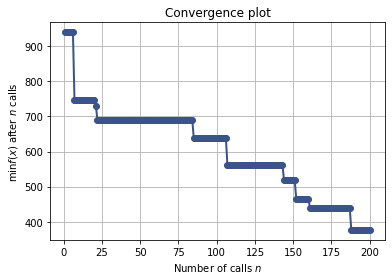

In [69]:
skplt.plot_convergence(res3);

In [70]:
from skopt import dump, load

In [71]:
dump(res3, 'result_200_iter.pkl')

In [72]:
from skopt import Optimizer
from joblib import Parallel, delayed

In [73]:
res_loaded = load('result_200_iter.pkl')
x0 = res_loaded.x_iters
y0 = list(res_loaded.func_vals)

In [74]:
opt = Optimizer(
    dimensions=[(0.01, 10.0), (0.0, 4.0), (0.0, 4.0), (0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5)],
    random_state=123,
    base_estimator='gp',
    n_initial_points=1
)

In [75]:
opt.tell(x0, y0);

In [76]:
%%time
for i in range(10):
    x = opt.ask(n_points=4)  # x is a list of n_points points
    y = Parallel(n_jobs=4)(delayed(toMinimize3)(v) for v in x)  # evaluate points in parallel
    opt.tell(x, y)

KeyboardInterrupt: 

In [104]:
min(opt.yi)


701.2796041631033

In [77]:
from scipy.optimize import fmin_l_bfgs_b

In [100]:
res5 = fmin_l_bfgs_b(toMinimize3,
                     [ 1.0282752 , 20.51287915,  0.16880172,  0.13243282,  0.06330424,
                       0.09109119,  0.06852974,  0.07307468,  0.0810518 ,  0.14960758,
                       0.06924349,  0.0627621 ,  0.07734331,  0.07542613,  0.4177983 ,
                       0.1263188 ,  0.14790044,  0.19316342,  0.10031524,  0.13221806,
                       0.08912528,  0.13193445,  0.05755433,  0.1516172 ,  0.17245183,
                       0.0637139 ,  0.10774846,  0.0579212 ],
              approx_grad=True,
              bounds=[(0.001, 10), (0.0, 100.0), (0.0, 10.0), (0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0)],
              epsilon=1e-08,
              maxfun=4000)

In [101]:
res5[1]

170.62419947064163

In [102]:
res5

(array([ 1.03167574, 20.51289592,  0.16905155,  0.13269757,  0.06342657,
         0.09125252,  0.06869503,  0.07321786,  0.08122377,  0.14983231,
         0.06939498,  0.06289812,  0.0774726 ,  0.07556352,  0.41809318,
         0.12656836,  0.14811513,  0.19347998,  0.10048894,  0.13244663,
         0.08929278,  0.13217488,  0.05768676,  0.15184328,  0.17279631,
         0.0638339 ,  0.10795655,  0.05803231]),
 170.62419947064163,
 {'grad': array([-1.15392141e-03, -3.80850875e-04,  1.75248260e-02,  8.69704309e-04,
          1.90425453e-04,  4.42810233e-03,  7.04858394e-04,  2.27373676e-04,
          1.25055522e-04, -3.55271368e-04,  4.37694325e-04,  6.38067377e-03,
         -2.60058641e-03,  2.14583906e-03,  3.27702310e-03,  2.04636308e-04,
         -6.62225830e-04,  7.10542736e-05, -6.25277608e-05,  1.02318154e-04,
          0.00000000e+00,  8.52651283e-05,  2.61479727e-04, -4.77484719e-04,
          2.98427949e-04, -1.35031542e-02, -3.58113539e-04, -7.07416348e-03]),
  'task': 'CONVE

In [81]:
def toMinimize31(params):
    params = np.insert(np.asarray(params), 1, [0, 0])
    return toMinimizeHelper3(params, N, distances, raw_data)

In [82]:
# distance null hypothesis with 25 Nsec
res51 = fmin_l_bfgs_b(toMinimize31,
                      [1.16446355, 0.03497285, 0.01517706, 0.02204523, 0.01564063,
                       0.01743337, 0.01862587, 0.0385814 , 0.01674298, 0.01479528,
                       0.01904643, 0.0183514 , 0.16100114, 0.02905405, 0.0379116 ,
                       0.05263438, 0.02497275, 0.03419347, 0.02163831, 0.03342023,
                       0.01306297, 0.03953913, 0.04202838, 0.01570377, 0.02580478,
                       0.01422764],
                     approx_grad=True,
                     bounds=[(0.001, 10), (0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0)],
                     epsilon=1e-08,
                     maxfun=4000)

In [83]:
sim_data = simulate3(res5[0], N, distances, raw_data)

In [84]:
sim_df = pd.DataFrame({'Event start date':sim_data[:, 0], 'Oblast':sim_data[:, 1], 'Number of events':sim_data[:, 2],
                       'Number of protesters':sim_data[:, 3], 'Simulated':sim_data[:, 4], 'loss':sim_data[:, 5]})

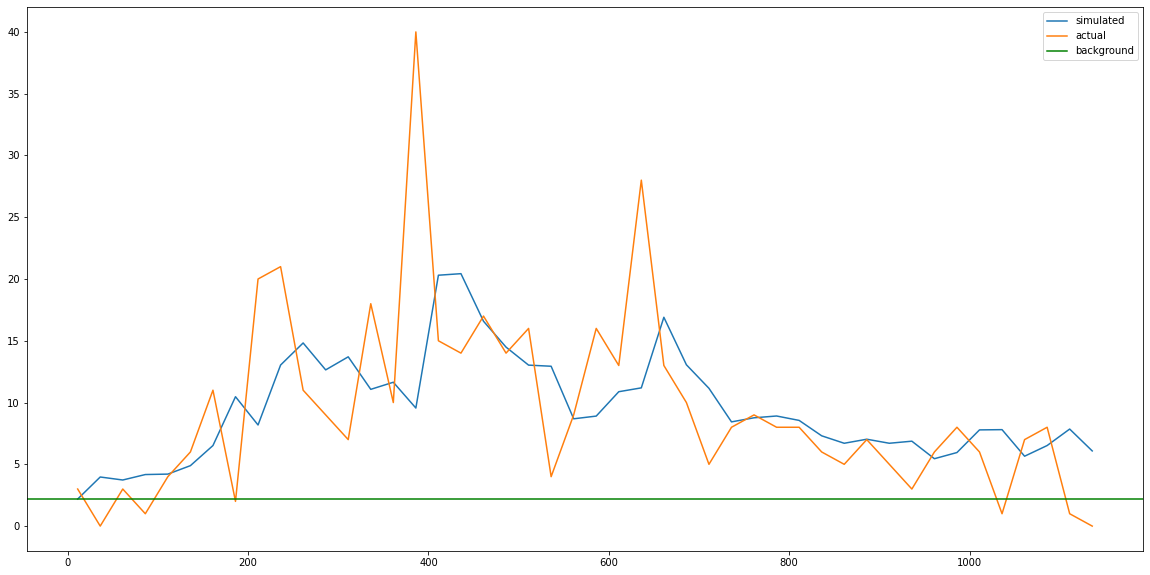

In [85]:
oblast = oblast_int['Kyiv']
plt.figure(figsize=(20,10))
plt.plot(sim_df.loc[sim_df['Oblast']==oblast]['Simulated'], label='simulated')
plt.plot(sim_df.loc[sim_df['Oblast']==oblast]['Number of events'], label='actual')
plt.axhline(y=N[oblast], color='g', label='background')
plt.legend()

In [86]:
computeLoss(sim_df.loc[sim_df['Oblast']==oblast]['Simulated'], sim_df.loc[sim_df['Oblast']==oblast]['Number of events'])


-578.6014909959224

In [87]:
res51

# With distance: 170.6, w/ out: 176.3

(array([1.16446355, 0.03497284, 0.01517705, 0.02204516, 0.01564061,
        0.01743333, 0.01862583, 0.0385814 , 0.01674298, 0.01479535,
        0.01904626, 0.01835154, 0.1610011 , 0.02905399, 0.03791159,
        0.05263433, 0.02497275, 0.03419347, 0.02163827, 0.03342021,
        0.01306282, 0.03953913, 0.04202836, 0.01570384, 0.02580474,
        0.01422762]),
 176.33178461405092,
 {'grad': array([-1.53477232e-04,  4.29167812e-04, -1.76214598e-04,  3.55271368e-04,
          2.52953214e-04,  9.94759830e-05,  8.18545231e-04,  4.26325641e-05,
         -1.39266376e-04,  1.05728759e-03, -1.61719527e-03,  2.57784904e-03,
          3.27986527e-03,  1.59161573e-03,  2.24531504e-04,  2.73416845e-03,
         -4.26325641e-05, -2.16004992e-04,  4.17799129e-04,  5.17275112e-04,
          2.56079602e-03,  1.62003744e-04,  6.65068001e-04,  1.17950094e-03,
          4.57589522e-04, -3.49587026e-04]),
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'funcalls': 108,
  'nit': 1,
  'warnfla

In [88]:
# Apply scipy optimize to previous trials

res6 = fmin_l_bfgs_b(toMinimize,
                     [0.3, 3, 2, 2],
                     approx_grad=True,
                     bounds=[(0.0, 2.0), (0.0001, 10.0), (0.0, 10.0), (0.0, 10.0)],
                     epsilon=1e-08,
                     maxfun=4000)

In [89]:
res6

(array([0.5445239 , 2.05990348, 1.76504333, 0.62143145]),
 247.79228538781916,
 {'grad': array([ 2.44710917e-03,  6.53699321e-05, -2.41556110e-02,  1.57172052e-03]),
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'funcalls': 185,
  'nit': 26,
  'warnflag': 0})

In [90]:
# Null hypothesis
res7 = fmin_l_bfgs_b(toMinimize2,
                     [0.03, 0.8],
                     approx_grad=True,
                     bounds=[(0.0, 2.0), (0.00001, 10.0)],
                     epsilon=1e-08,
                     maxfun=4000)

In [91]:
res7

(array([0.02798585, 0.82226845]),
 434.2810988147176,
 {'grad': array([-1.06297193e-03,  2.27373674e-05]),
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'funcalls': 30,
  'nit': 7,
  'warnflag': 0})

In [92]:
# Try adding a parameter to scale by # of protesters
@njit
def toMinimizeHelper4(params, N0s, dists, raw):
    raw_copy = raw.copy()
    distance_weights = [[1/(np.power((params[2] * dists[i][j] + 1), params[3])) for j in range(0, 25)] for i in range(0, 25)]
    for i in range(0, 46):
        for j in range(25*i, 25*(i+1)):
            psum = np.array([distance_weights[int(raw_copy[j][1])][int(raw_copy[x][1])] *
                              np.log(params[4] * raw_copy[x][3]+1) *
                             (raw_copy[x][2]*(np.exp((-(i-raw_copy[x][0]-1))/params[1])
                                              - np.exp(-(i-raw_copy[x][0])/params[1]))) for x in range(0, i*25)])
            raw_copy[j][4] = N0s[int(raw_copy[j][1])] + params[0] * psum.sum()
            if j != 0:
                raw_copy[j][5] = raw_copy[j-1][5] + (raw_copy[j][4] - (raw_copy[j][2] * np.log(raw_copy[j][4])))
            # if np.isnan(psum.sum()):
            #     print(i)
            #     print(j)
            #     print(params)
    # print(raw_copy[1149][5])
    return raw_copy[1149][5]

In [93]:
def toMinimize4(params):
    params = np.asarray(params)
    return toMinimizeHelper4(params, N, distances, raw_data)


In [94]:
res8 = fmin_l_bfgs_b(toMinimize4,
                     [0.3, 0.8, 1.0, 1.0, 1.0],
                     approx_grad=True,
                     bounds=[(0.0, 2.0), (0.0001, 10.0), (0.0, 10000.0), (0.0, 10.0), (0.0, 10000.0)],
                     epsilon=1e-08,
                     maxfun=4000)

In [95]:
res8

(array([4.44656217e-02, 2.00356717e+00, 3.55370253e+03, 2.40228289e-01,
        1.00931637e+02]),
 249.43743258322533,
 {'grad': array([ 2.49326888e+00, -3.97335500e-03,  2.84220100e-06, -3.08187964e-01,
          1.44950809e-04]),
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'funcalls': 1614,
  'nit': 179,
  'warnflag': 0})

In [96]:
%%time
res9 = gp_minimize(toMinimize4, [(0.0, 0.5), (0.0001, 10.0), (0.0, 2000.0), (0.0, 20.0), (0.0, 1000.0)],
                   n_calls=160, noise=1e-10, n_initial_points=10, n_jobs=-1, random_state=123)

CPU times: user 2min 27s, sys: 19.9 s, total: 2min 47s
Wall time: 2min 16s


In [97]:
res9.x

[0.06626926428546391,
 3.4370478125734194,
 457.83502613758856,
 6.0336255962265275,
 886.1815501151882]

In [98]:
res9.fun

355.039787036536

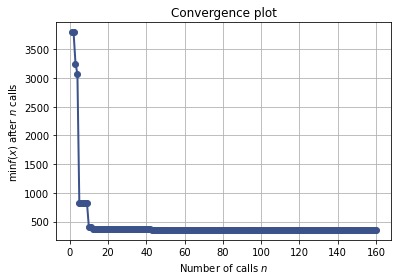

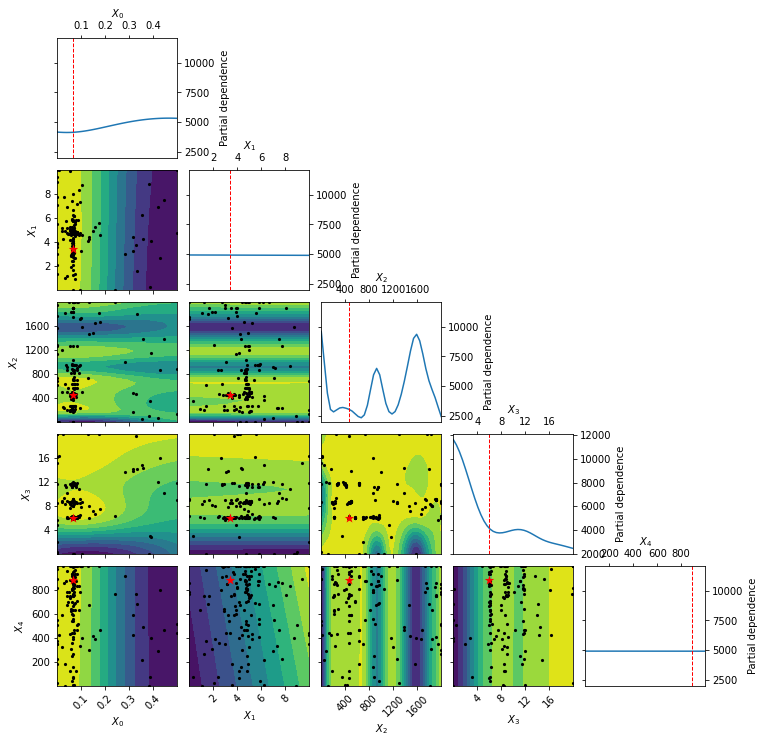

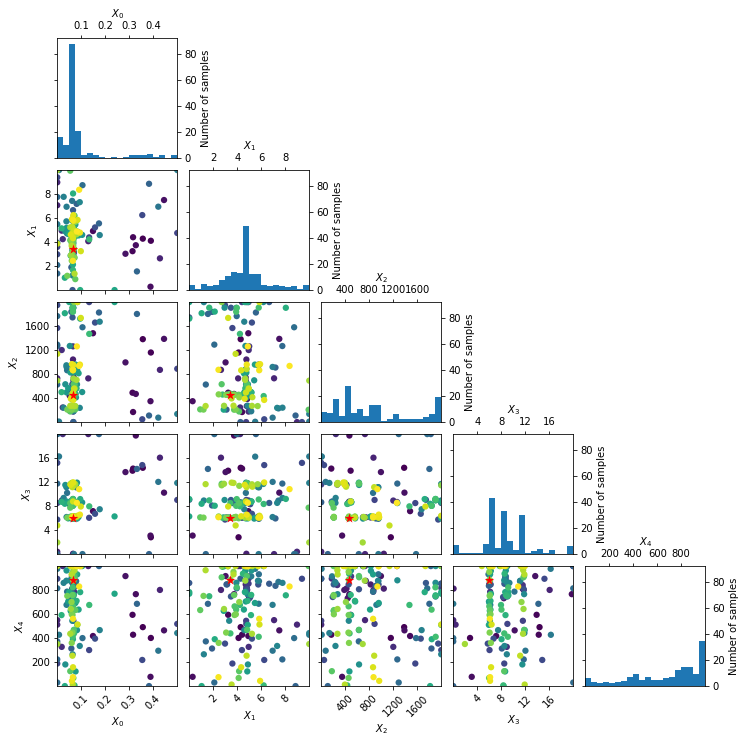

In [99]:
skplt.plot_convergence(res9);
skplt.plot_objective(res9);
skplt.plot_evaluations(res9);

In [62]:
opt = Optimizer(
    dimensions=[(0.0, 0.5), (0.0001, 10.0), (0.0, 4.0), (0.0, 20.0), (0.0, 10.0)],
    random_state=123,
    base_estimator='gp',
    n_initial_points=10
)

In [63]:
%%time
for i in range(20):
    x = opt.ask(n_points=4)  # x is a list of n_points points
    y = Parallel(n_jobs=4)(delayed(toMinimize4)(v) for v in x)  # evaluate points in parallel
    opt.tell(x, y)

CPU times: user 5min 11s, sys: 40.6 s, total: 5min 52s
Wall time: 2min 3s


In [64]:
min(opt.yi)


395.41829667450486

In [ ]:
# need to try adding a scaling param to an average background
# and then see if distance beats null-hypothesis